In [4]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import lsstypes as types
import matplotlib.pyplot as plt
from desilike import setup_logging
setup_logging()  # for logging messages

sys.path.append('../')
from fitting_tools import load_blinded_data_pip, load_bins, get_template, get_theory, get_measurement_fn, get_observable_likelihood
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def load_mesh2_spectrum_poles(filename):
    result = types.read(filename)
    k = result.get(ells=0).coords('k')
    Pk = {ell: result.get(ells=ell).values() for ell in result.ells}
    return k, Pk

In [3]:
fn =  f'/pscratch/sd/s/shengyu/Y3/blinded/test/mesh2_spectrum_poles_LRG_z0.4-0.6_{{}}_default_fkp.h5'

fig = plt.figure(figsize = (7, 5))
for inds, region in enumerate(['NGC','SGC','GCcomb']):
    k,Pk = load_mesh2_spectrum_poles(fn.format(region))
    for ell in [0,2]:
        label = region if ell==0 else None
        plt.plot(k,k*Pk[ell]['value'], color = f'C{inds}', label = label)
plt.legend()

NameError: name 'load_mesh2_spectrum_poles' is not defined

<Figure size 700x500 with 0 Axes>

In [7]:
tracer = 'LRG'
region = 'NGC'
zrange = (0.4,0.6)

data_args = {'tracer':tracer, 'zrange':zrange, 'region':region, 'weight_type':'default_fkp'}
data, wmatrix, covariance = load_blinded_data_pip(data_args)

In [8]:
task = 'FM_fit_folps'

fit_args = {"corr_type": 'pk',  "bins_type": 'y3_blinding', "cov_type":None}

(likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)

In [9]:
theory.z

array(0.50968785)

In [10]:
for param in likelihood.varied_params:
    print(param, param.prior)

h uniform[0.2, 1.0]({})
omega_cdm uniform[0.01, 0.99]({})
omega_b norm({'loc': 0.02237, 'scale': 0.00055})
logA uniform[1.61, 3.91]({})
n_s norm({'loc': 0.9649, 'scale': 0.042})
b1p uniform[0.0, 3.0]({})
b2p norm({'loc': 0.0, 'scale': 5.0})
bsp norm({'loc': 0.0, 'scale': 5.0})
alpha0p norm({'loc': 0.0, 'scale': 12.5})
alpha2p norm({'loc': 0.0, 'scale': 12.5})
alpha4p norm({'loc': 0.0, 'scale': 12.5})
sn0p norm({'loc': 0.0, 'scale': 2.0})
sn2p norm({'loc': 0.0, 'scale': 5.0})


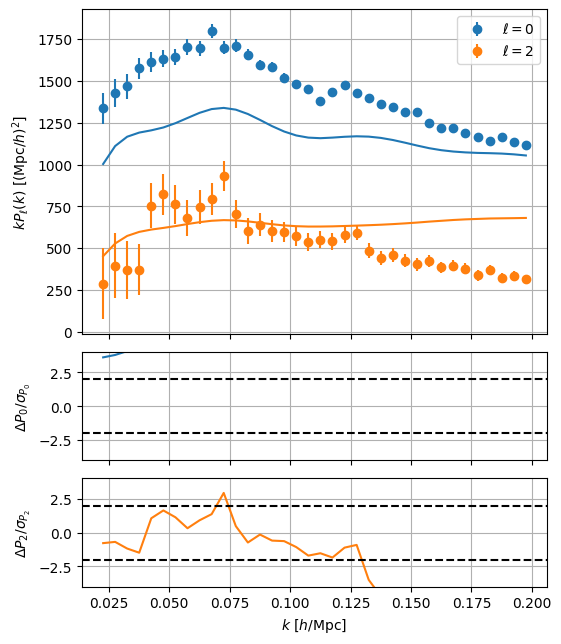

In [11]:
fit = observable.plot()

In [ ]:
# from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine
# emulator = Emulator(theory.pt, engine=TaylorEmulatorEngine(order=3, method='finite')) # Taylor expansion, up to a given order
# emulator.set_samples() # evaluate the theory derivatives (with jax auto-differentiation if possible, else finite differentiation)
# emulator.fit()
# emulator.save('./tests/emulator.npy')

KeyboardInterrupt: 

In [12]:
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine
pt = EmulatedCalculator.load('./tests/emulator.npy')

[000045.70] [0/1] 12-01 05:21  Emulator                  INFO     Loading ./tests/emulator.npy.


[000046.66] [0/1] 12-01 05:21  Emulator                  INFO     Loading ./tests/emulator.npy.
[000046.71] [0/1] 12-01 05:21  MinuitProfiler            INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'b1p', 'b2p', 'bsp', 'alpha0p', 'alpha2p', 'alpha4p', 'sn0p', 'sn2p'].
[000046.75] [0/1] 12-01 05:21  MinuitProfiler            INFO     Successfully jit input likelihood.


/global/homes/s/shengyu/.conda/envs/fit_env/lib/python3.11/site-packages/desilike/jax.py:29: UserWarning: Could *not* import jax and dependencies, got error:
Traceback (most recent call last):
  File "/global/homes/s/shengyu/.conda/envs/fit_env/lib/python3.11/site-packages/desilike/jax.py", line 16, in <module>
    import jax, jaxlib
ModuleNotFoundError: No module named 'jaxlib'
. You will not be able to analytically marginalize parameters.
  warnings.warn('Could *not* import jax and dependencies, got error:\n{}. You will not be able to analytically marginalize parameters.'.format(traceback.format_exc()))


+--------------------------------------+--------+---------+---------+
| chi2 / (72 - 13) = 65.22 / 59 = 1.11 | varied | bestfit |  error  |
+--------------------------------------+--------+---------+---------+
|                  h                   |  True  |  0.698  |  0.016  |
|              omega_cdm               |  True  | 0.1118  | 0.0070  |
|               omega_b                |  True  | 0.02239 | 0.00054 |
|                 logA                 |  True  |  3.07   |  0.13   |
|                 n_s                  |  True  |  0.965  |  0.029  |
|                 b1p                  |  True  |  1.163  |  0.018  |
|                 b2p                  |  True  |  -0.63  |  0.23   |
|                 bsp                  |  True  |  1.17   |  0.38   |
|               alpha0p                |  True  |   6.6   |   2.0   |
|               alpha2p                |  True  |  -13.3  |   8.5   |
|               alpha4p                |  True  |   -9    |   10.   |
|                 sn

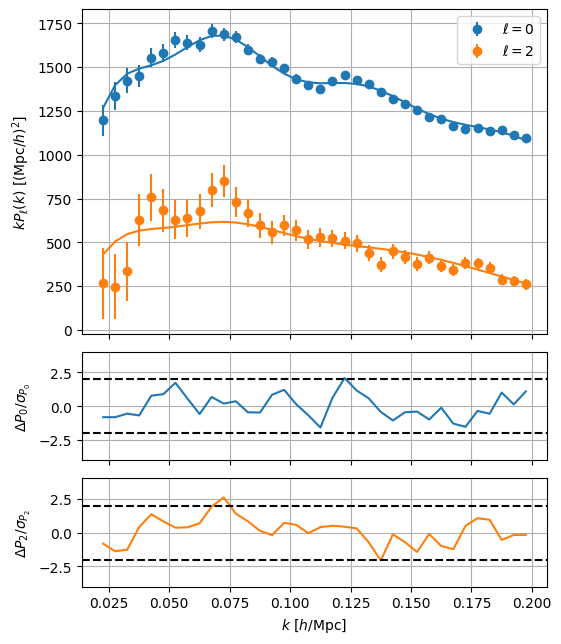

In [13]:
from desilike.profilers import MinuitProfiler
from desilike.likelihoods import ObservablesGaussianLikelihood

theory_el = theory.init.update(pt=EmulatedCalculator.load('./tests/emulator.npy'))
likelihood_el = ObservablesGaussianLikelihood(observables=observable, theory=theory_el)
profiler = MinuitProfiler(likelihood_el, seed=42)
profiles = profiler.maximize()
print(profiles.to_stats(tablefmt='pretty'))
print(-2*likelihood_el(**profiles.bestfit.choice(input=True)))
fig = observable.plot()

In [10]:
from desilike.samplers.emcee import EmceeSampler

# MCMC sampling
nwalkers = 64
iterations = 20001 # save every 300 iterations
sampler = EmceeSampler(likelihood_el, seed=42, nwalkers=nwalkers, save_fn = './tests/chain.npy')
sampler.run(max_iterations = iterations) # save every 300 iterations,

[000375.25] [0/1] 12-01 04:16  EmceeSampler              INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'b1p', 'b2p', 'bsp', 'alpha0p', 'alpha2p', 'alpha4p', 'sn0p', 'sn2p'].
[000375.26] [0/1] 12-01 04:16  EmceeSampler              INFO     Could *not* vmap input likelihood. Set logging level to debug (setup_logging("debug")) to get full stack trace.
[000375.26] [0/1] 12-01 04:16  EmceeSampler              INFO     Successfully jit input likelihood.


[000482.09] [0/1] 12-01 04:18  Chain                     INFO     Saving ./tests/chain.npy.
[000587.93] [0/1] 12-01 04:20  Chain                     INFO     Saving ./tests/chain.npy.
[000697.51] [0/1] 12-01 04:21  Chain                     INFO     Saving ./tests/chain.npy.
[000804.21] [0/1] 12-01 04:23  Chain                     INFO     Saving ./tests/chain.npy.
[000910.90] [0/1] 12-01 04:25  Chain                     INFO     Saving ./tests/chain.npy.
[001017.09] [0/1] 12-01 04:27  Chain                     INFO     Saving ./tests/chain.npy.
[001123.50] [0/1] 12-01 04:29  Chain                     INFO     Saving ./tests/chain.npy.
[001229.01] [0/1] 12-01 04:30  Chain                     INFO     Saving ./tests/chain.npy.
[001331.42] [0/1] 12-01 04:32  Chain                     INFO     Saving ./tests/chain.npy.
[001434.89] [0/1] 12-01 04:34  Chain                     INFO     Saving ./tests/chain.npy.
[001537.00] [0/1] 12-01 04:35  Chain                     INFO     Saving ./tests

Traceback (most recent call last):
  File "/global/homes/s/shengyu/.conda/envs/fit_env/lib/python3.11/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/global/homes/s/shengyu/.conda/envs/fit_env/lib/python3.11/site-packages/desilike/samplers/base.py", line 61, in wrapper
    toret[mask] = func(self, values)
                  ^^^^^^^^^^^^^^^^^^
  File "/global/homes/s/shengyu/.conda/envs/fit_env/lib/python3.11/site-packages/desilike/samplers/base.py", line 151, in logposterior
    results = self._vlikelihood(points.to_dict())
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/global/homes/s/shengyu/.conda/envs/fit_env/lib/python3.11/site-packages/desilike/samplers/base.py", line 264, in _vlikelihood
    return vlikelihood(*args, **kwargs, mpicomm=self.mpicomm)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/global/homes/s/shengyu/.conda/envs/fit_e

KeyboardInterrupt: 

[000020.83] [0/1] 12-01 05:21  Chain                     INFO     Loading ./tests/chain.npy.


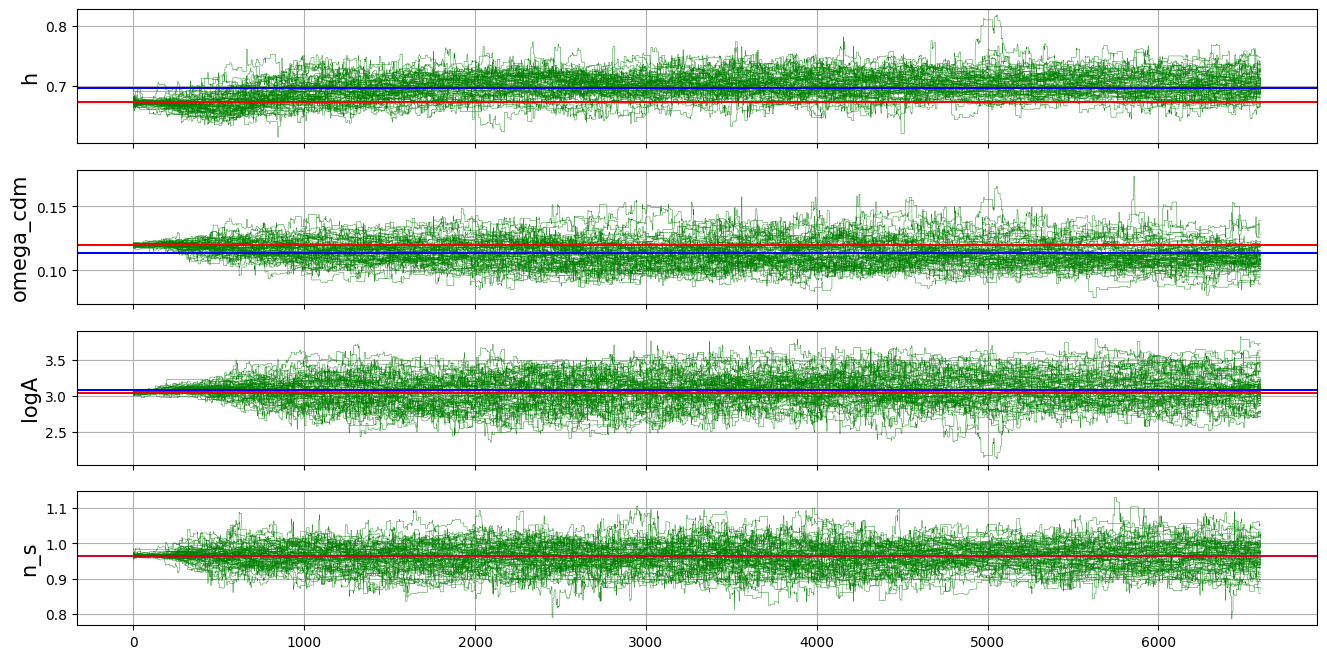

In [5]:
from desilike.samples import plotting, Chain
from plotting_tools import plot_observable, plot_mcmc_walkers, convert_chain
from helper import PLANCK_COSMOLOGY

nwalkers = 64

params = ['h', 'omega_cdm', 'logA','n_s']
chain_fn = './tests/chain.npy'
chain   = Chain.load(chain_fn)
true_values = [PLANCK_COSMOLOGY[param] for param in params]
plot_mcmc_walkers(chain, params, nwalkers, true_values)

[000115.28] [0/1] 12-01 05:23  Chain                     INFO     Loading ./tests/chain.npy.


chi2: 68.97257527712432
+-----------+---------+---------+---------+---------+-----------------+-----------------+
|           | argmax  |  mean   | median  |   std   | quantile:1sigma | interval:1sigma |
+-----------+---------+---------+---------+---------+-----------------+-----------------+
|     h     |  0.709  |  0.703  |  0.704  |  0.018  |  -0.019/+0.018  |  -0.019/+0.018  |
| omega_cdm |  0.113  |  0.113  |  0.112  |  0.010  | -0.0088/+0.0114 | -0.0104/+0.0070 |
|  omega_b  | 0.02297 | 0.02243 | 0.02242 | 0.00055 | -5.5e-4/+5.3e-4 | -5.5e-4/+5.3e-4 |
|   logA    |  3.15   |  3.08   |  3.07   |  0.21   |   -0.21/+0.21   |   -0.17/+0.24   |
|    n_s    |  0.951  |  0.963  |  0.963  |  0.037  |  -0.034/+0.039  |  -0.035/+0.035  |
|    b1p    |  1.151  |  1.154  |  1.156  |  0.048  |  -0.040/+0.043  |  -0.031/+0.051  |
|    b2p    |  -0.38  |  -0.61  |  -0.64  |  0.56   |   -0.56/+0.50   |   -0.53/+0.51   |
|    bsp    |   0.0   |   1.3   |   1.3   |   1.1   |    -1.1/+1.2    |   -1

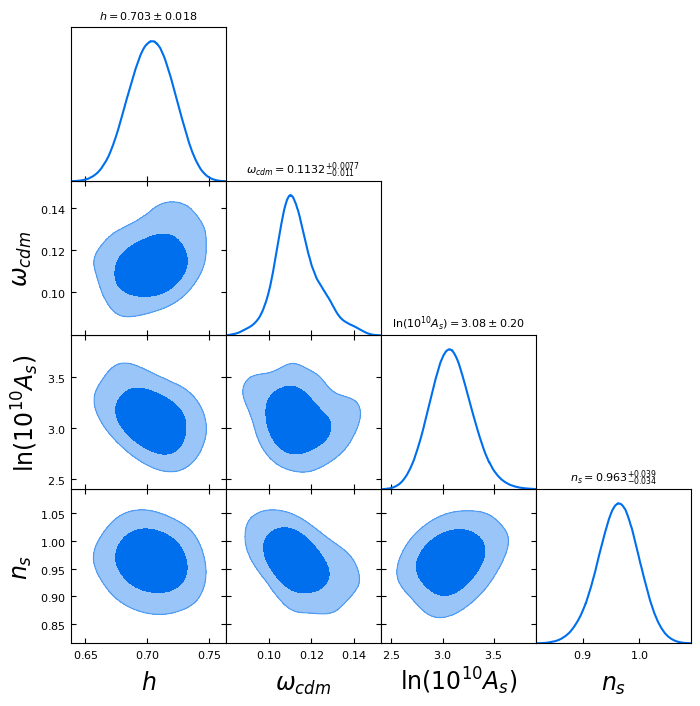

In [18]:
from getdist import plots

burnin = 0.4
slice_step = 1000
chain = Chain.load(chain_fn).remove_burnin(burnin)[::slice_step]
print('chi2:',-2*likelihood_el(**chain.choice(index='argmax', return_type='dict', input=True)))
print(chain.to_stats(tablefmt='pretty'))
g = plots.get_subplot_plotter()
g.settings.fig_width_inch= 8
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.settings.figure_legend_frame = False
plotting.plot_triangle(chain, title_limit=1, filled = True, params = params, contour_lws = 1.5,
                            smoothed=True, show=False, g=g)
def set_true_values(fit, params):
    if fit == 'SF':
        return [1,1,0,1]
    if fit == 'FM':
        return [PLANCK_COSMOLOGY[param] for param in params if param in PLANCK_COSMOLOGY]
# true_values     = set_true_values(fit, params)
# for i in range(len(true_values)):
#     for j in range(i+1):
#         g.subplots[i,j].axvline(true_values[j], c = 'k', ls = ':', lw = 1.2)
#         if i != j:
#             g.subplots[i,j].axhline(true_values[i], c = 'k', ls = ':', lw = 1.2)